## Each algorithm

--- Analyzing: CEGAR_PRED ---


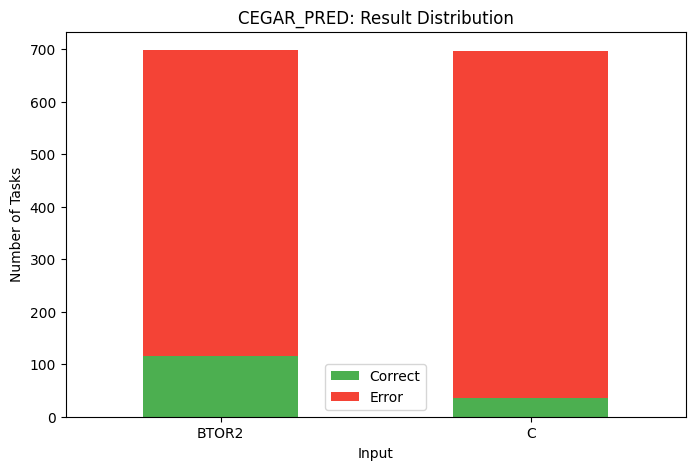

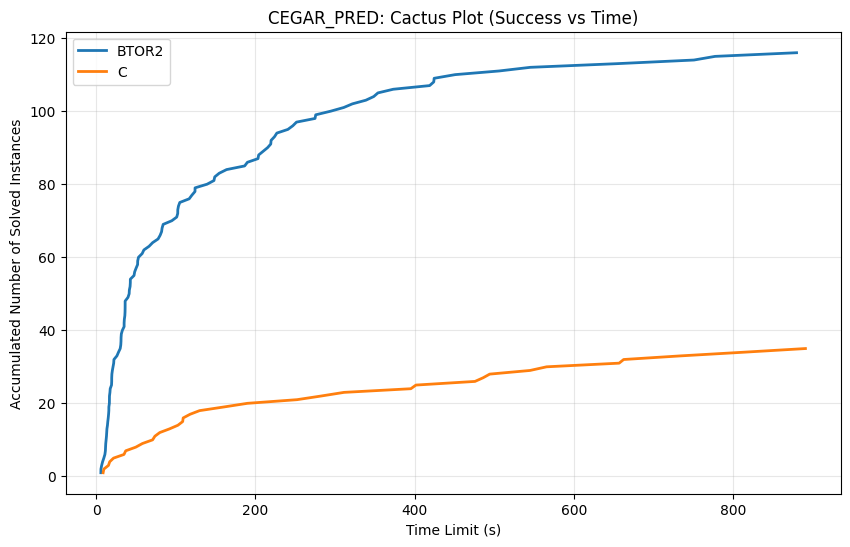

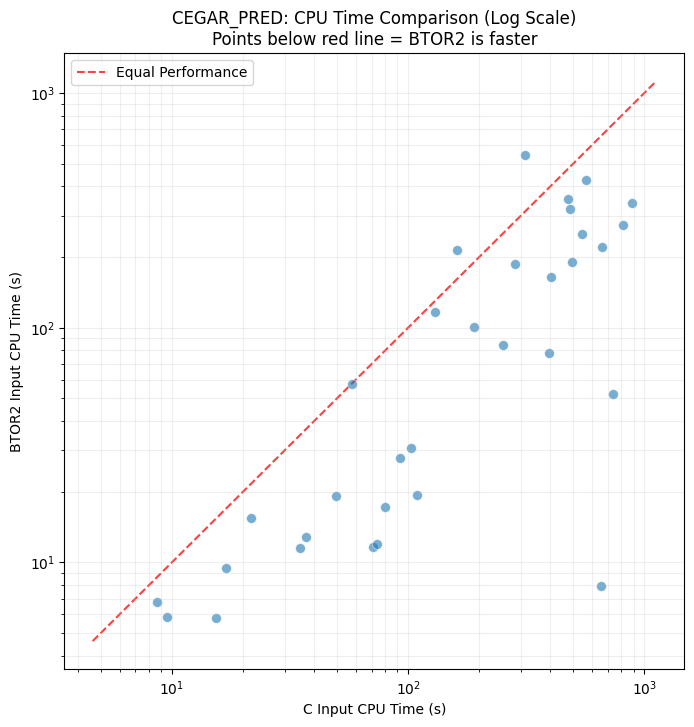



--- Analyzing: CEGAR_EXPL ---


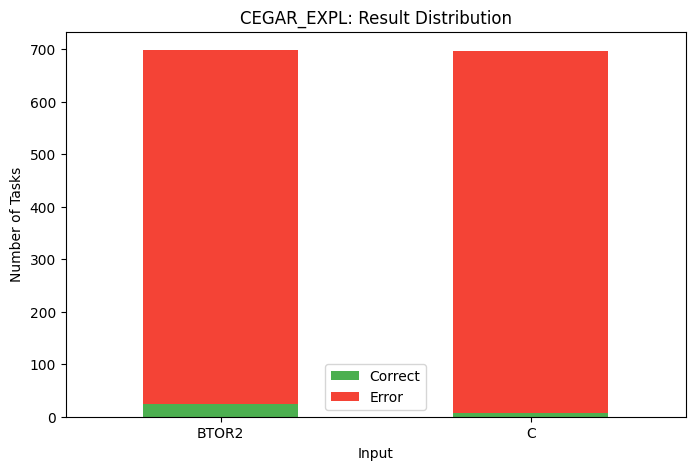

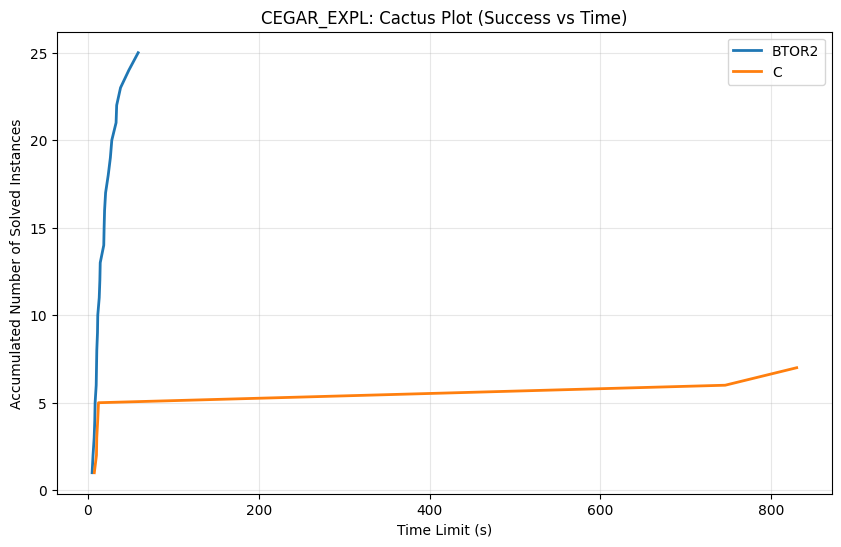

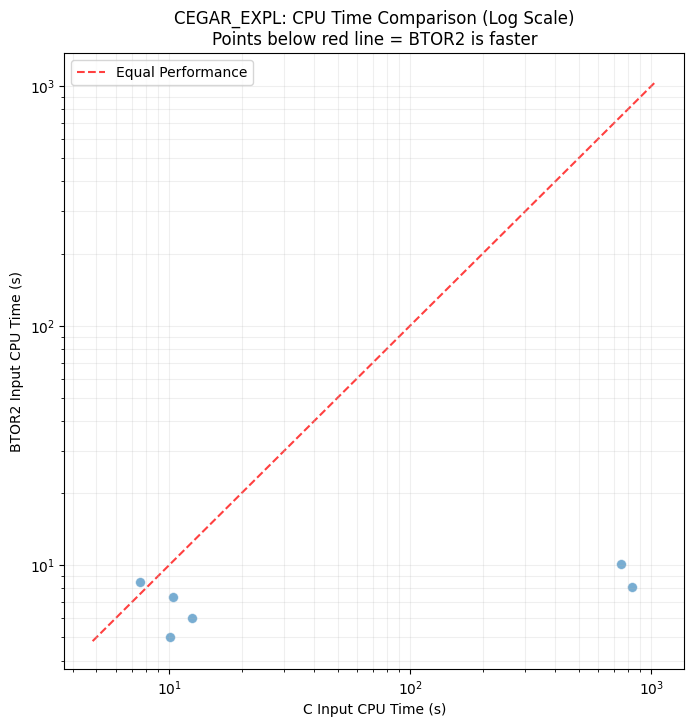



--- Analyzing: BMC ---


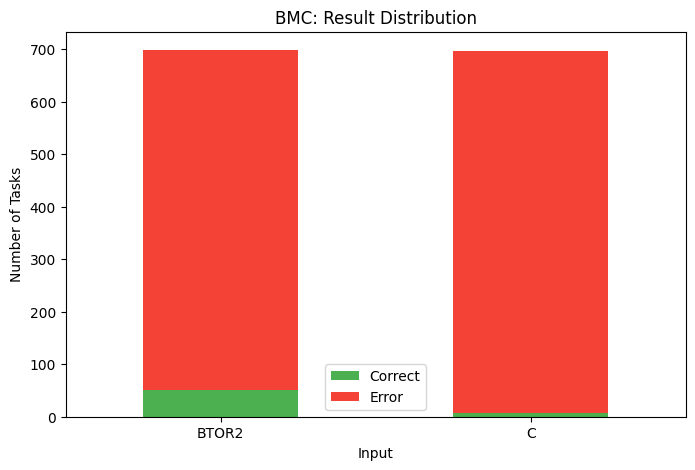

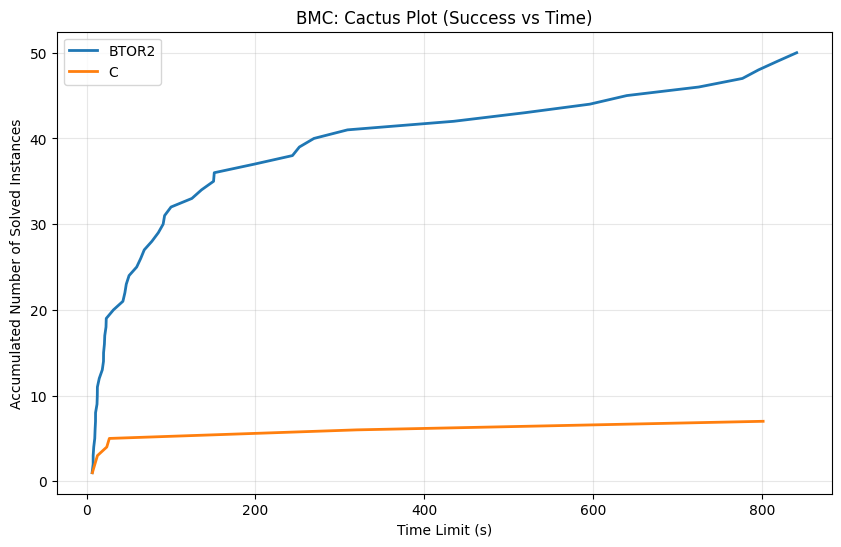

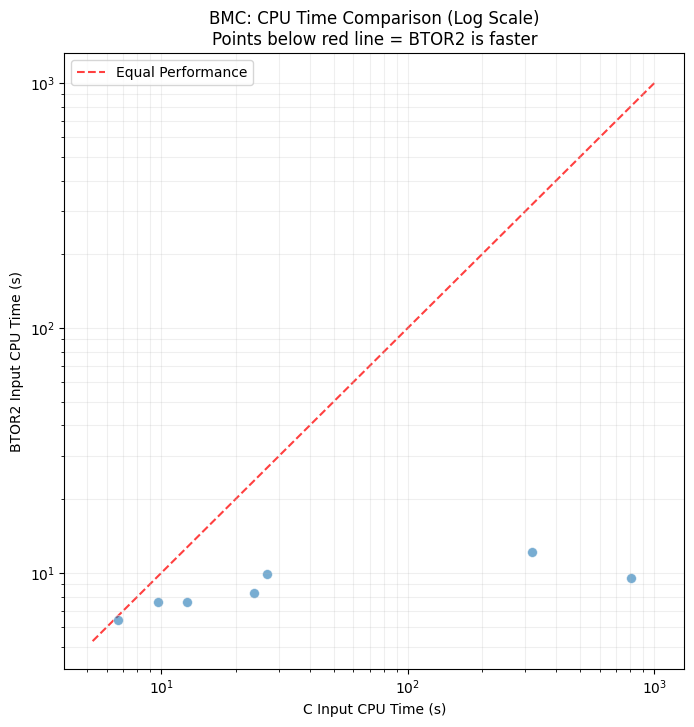



--- Analyzing: IMC ---


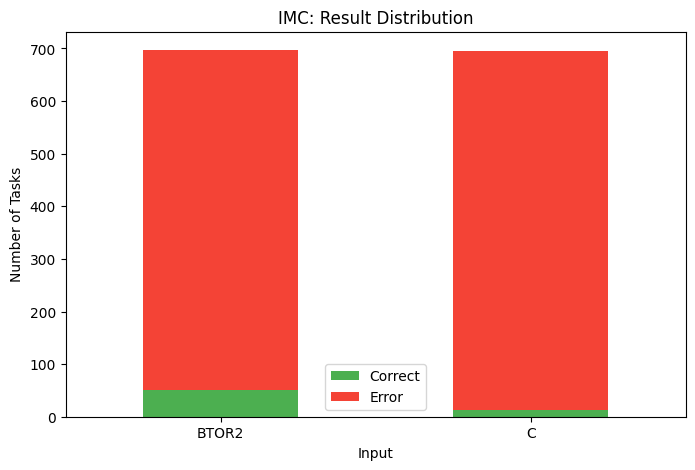

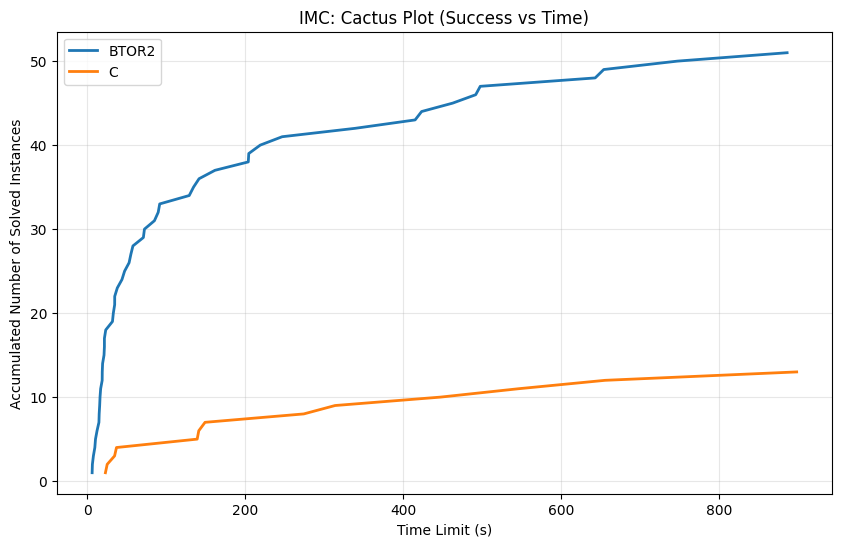

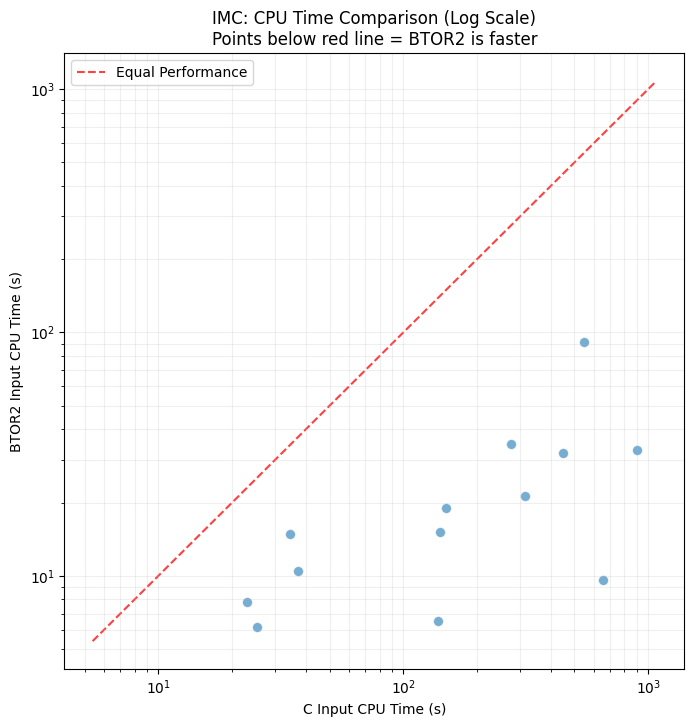



--- Analyzing: K-Induction ---


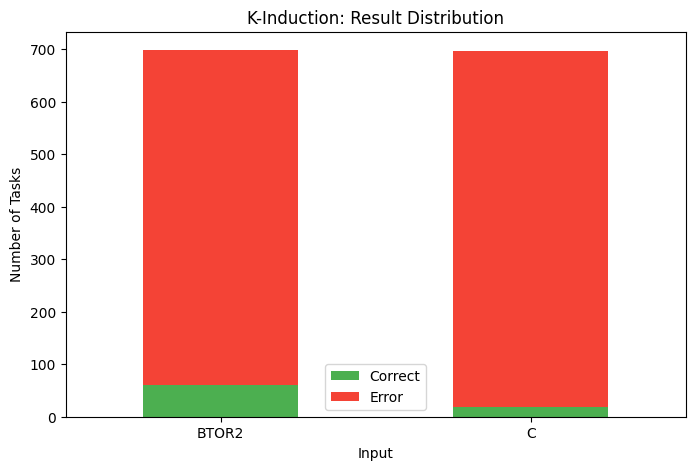

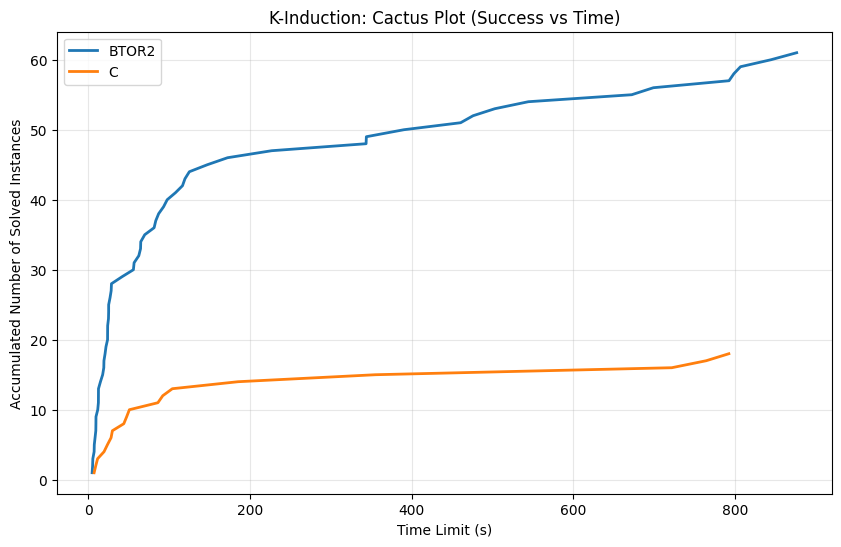

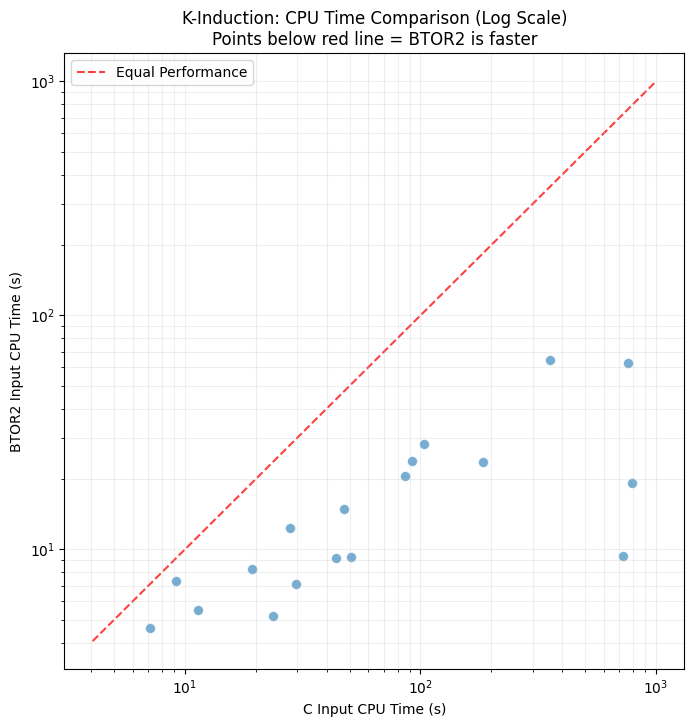

In [1]:
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Configuration ---
# Define your folder name
DATA_FOLDER = "result_xmls"

# Update the PAIRS list to join the folder with the filename
PAIRS = [
    ("CEGAR_PRED", 
     os.path.join(DATA_FOLDER, "btor2-algos-opt.2025-12-07_02-16-12.results.btor2-pred-cegar.btor2-pred.xml"), 
     os.path.join(DATA_FOLDER, "c-algos.2025-12-07_02-30-26.results.c-pred-cegar.c-pred.xml")),
    ("CEGAR_EXPL", 
     os.path.join(DATA_FOLDER, "btor2-algos-opt.2025-12-07_02-16-12.results.btor2-expl-cegar.btor2-expl.xml"), 
     os.path.join(DATA_FOLDER, "c-algos.2025-12-07_02-30-26.results.c-expl-cegar.c-expl.xml")),
     ("BMC", 
     os.path.join(DATA_FOLDER, "btor2-algos-opt.2025-12-07_02-16-12.results.btor2-bounded.btor2.xml"), 
     os.path.join(DATA_FOLDER, "c-algos.2025-12-07_02-30-26.results.c-bounded.c.xml")),
     ("IMC", 
     os.path.join(DATA_FOLDER, "btor2-algos-opt.2025-12-07_02-16-12.results.btor2-imc.btor2.xml"), 
     os.path.join(DATA_FOLDER, "c-algos.2025-12-07_02-30-26.results.c-imc.c.xml")),
     ("K-Induction", 
     os.path.join(DATA_FOLDER, "btor2-algos-opt.2025-12-07_02-16-12.results.btor2-kind.btor2.xml"), 
     os.path.join(DATA_FOLDER, "c-algos.2025-12-07_02-30-26.results.c-kind.c.xml")),
]

# --- 1. XML Parsing Function ---
def parse_benchexec_xml(filepath):
    """Parses BenchExec XML and returns a DataFrame with clean types."""
    if not os.path.exists(filepath):
        print(f"Warning: File not found: {filepath}")
        return None

    tree = ET.parse(filepath)
    root = tree.getroot()
    
    data = []
    
    # Iterate through each run (benchmark task)
    for run in root.findall('.//run'):
        file_name = run.get('name')
        # specific columns are usually children tags
        cols = {elem.get('title'): elem.get('value') for elem in run.findall('column')}
        
        # Fallback for status if not in columns (older formats)
        status = cols.get('status')
        category = cols.get('category')
        
        # Clean CPU Time (remove 's')
        cpu_time = cols.get('cputime', 'nan')
        if isinstance(cpu_time, str):
            cpu_time = float(cpu_time.replace('s', ''))
            
        # Clean Memory (remove 'B', convert to MB)
        memory = cols.get('memory', 'nan')
        if isinstance(memory, str):
            memory = float(memory.replace('B', '')) / (1024 * 1024) # Convert to MB

        # Normalize Benchmark Name (remove extension to allow merging)
        # e.g., 'folder/task.btor2' -> 'task'
        base_name = os.path.splitext(os.path.basename(file_name))[0]

        data.append({
            'base_name': base_name,
            'full_name': file_name,
            'status': status,
            'category': category, # 'correct', 'error', 'unknown'
            'cputime': cpu_time,
            'memory_mb': memory
        })
        
    return pd.DataFrame(data)

# --- 2. Visualization Functions ---

def plot_cpu_scatter(df, algo_name):
    """Scatter plot: C Time (x) vs BTOR2 Time (y)"""
    plt.figure(figsize=(8, 8))
    
    # Filter only where both solved correctly for fair time comparison
    correct_df = df[(df['category_btor'] == 'correct') & (df['category_c'] == 'correct')]
    
    # Log scale is usually better for verification times
    plt.xscale('log')
    plt.yscale('log')
    
    sns.scatterplot(data=correct_df, x='cputime_c', y='cputime_btor', alpha=0.6, s=50)
    
    # Draw diagonal line (x=y)
    lims = [
        min(plt.xlim()[0], plt.ylim()[0]), 
        max(plt.xlim()[1], plt.ylim()[1])
    ]
    plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0, label='Equal Performance')
    
    plt.title(f"{algo_name}: CPU Time Comparison (Log Scale)\nPoints below red line = BTOR2 is faster")
    plt.xlabel("C Input CPU Time (s)")
    plt.ylabel("BTOR2 Input CPU Time (s)")
    plt.legend()
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.show()

def plot_cactus(df_btor, df_c, algo_name):
    """Cactus plot: Sorted time vs Number of solved instances"""
    plt.figure(figsize=(10, 6))
    
    for label, data in [('BTOR2', df_btor), ('C', df_c)]:
        # Filter correct runs and sort by time
        solved = data[data['category'] == 'correct']['cputime'].sort_values().reset_index(drop=True)
        plt.plot(solved, solved.index + 1, label=label, linewidth=2)
        
    plt.title(f"{algo_name}: Cactus Plot (Success vs Time)")
    plt.xlabel("Time Limit (s)")
    plt.ylabel("Accumulated Number of Solved Instances")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_status_bars(df_btor, df_c, algo_name):
    """Compare success/fail counts"""
    # Helper to count statuses
    def get_counts(df, label):
        counts = df['category'].value_counts()
        # Ensure we have keys even if 0
        return {
            'Input': label,
            'Correct': counts.get('correct', 0),
            'Error': counts.get('error', 0),
            #'Unknown/Timeout': len(df) - counts.get('correct', 0) - counts.get('error', 0)
        }

    stats = pd.DataFrame([get_counts(df_btor, 'BTOR2'), get_counts(df_c, 'C')])
    
    # Plotting
    stats.set_index('Input').plot(kind='bar', stacked=True, color=['#4CAF50', '#F44336', '#FF9800'], figsize=(8, 5))
    plt.title(f"{algo_name}: Result Distribution")
    plt.ylabel("Number of Tasks")
    plt.xticks(rotation=0)
    plt.show()

# --- 3. Main Execution Loop ---

for algo_name, btor_file, c_file in PAIRS:
    print(f"--- Analyzing: {algo_name} ---")
    
    df_btor = parse_benchexec_xml(btor_file)
    df_c = parse_benchexec_xml(c_file)
    
    if df_btor is not None and df_c is not None:
        # Merge for direct comparison (Scatter plot)
        # Suffixes help distinguish columns: _btor vs _c
        merged_df = pd.merge(
            df_btor, 
            df_c, 
            on='base_name', 
            how='inner', 
            suffixes=('_btor', '_c')
        )
        
        # 1. Status Bar Chart
        plot_status_bars(df_btor, df_c, algo_name)
        
        # 2. Cactus Plot (Solvability over time)
        plot_cactus(df_btor, df_c, algo_name)
        
        # 3. Scatter Plot (Performance on commonly solved)
        if len(merged_df) > 0:
            plot_cpu_scatter(merged_df, algo_name)
        else:
            print("No matching benchmark names found between BTOR2 and C files (check file naming conventions).")
            
    print("\n" + "="*50 + "\n")

Processing files...

--- Summary Comparison Table ---


Input Type    BTOR2                                                         \
            avg_cpu  avg_mem med_cpu med_mem std_cpu  std_mem success_rate   
Algorithm                                                                    
BMC          182.13   696.40   61.60  649.18  252.35   384.88         7.16   
CEGAR_EXPL    19.92   480.98   14.47  405.40   13.43   295.37         3.58   
CEGAR_PRED   134.67  1717.04   51.99  859.59  172.61  1859.61        16.62   
IMC          159.21  1060.91   52.98  750.75  216.72   890.43         7.31   
K-Induction  178.39   777.55   56.57  673.83  256.25   502.48         8.74   

Input Type        C                                                          
            avg_cpu  avg_mem med_cpu  med_mem std_cpu  std_mem success_rate  
Algorithm                                                                    
BMC          171.63  1070.70   23.76   304.83  277.89  1892.30         1.01  
CEGAR_EXPL   232.52  1696.30   11.53   297.23  351.92  2270.82         1.01  
CEGAR_PRED   270.11  4176.83  129.78  2990.98  259.44  3436.76         5.03  
IMC          283.48  3314.08  149.17  3085.55  267.46  3201.35         1.87  
K-Induction  187.27  2506.06   49.03  2686.79  268.60  2145.25         2.59

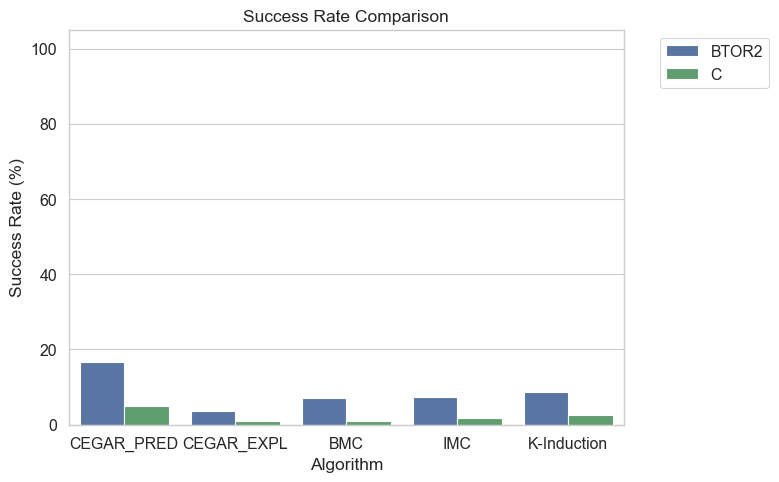

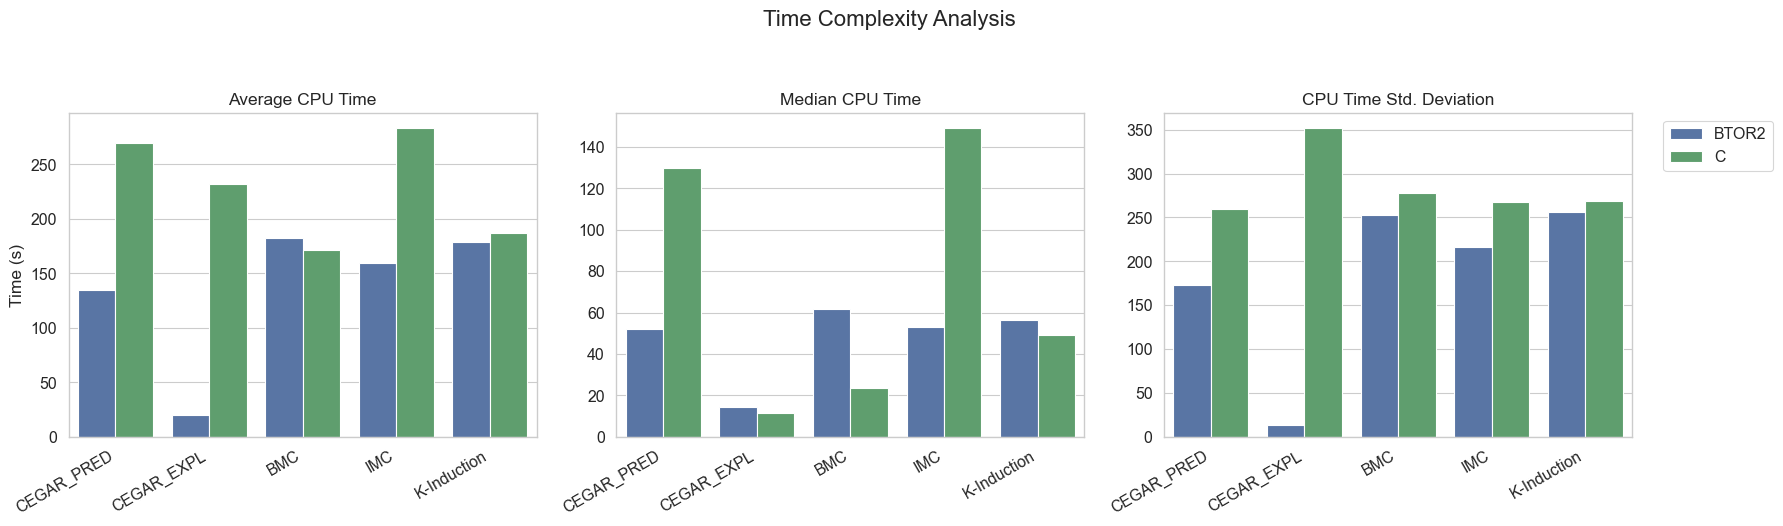

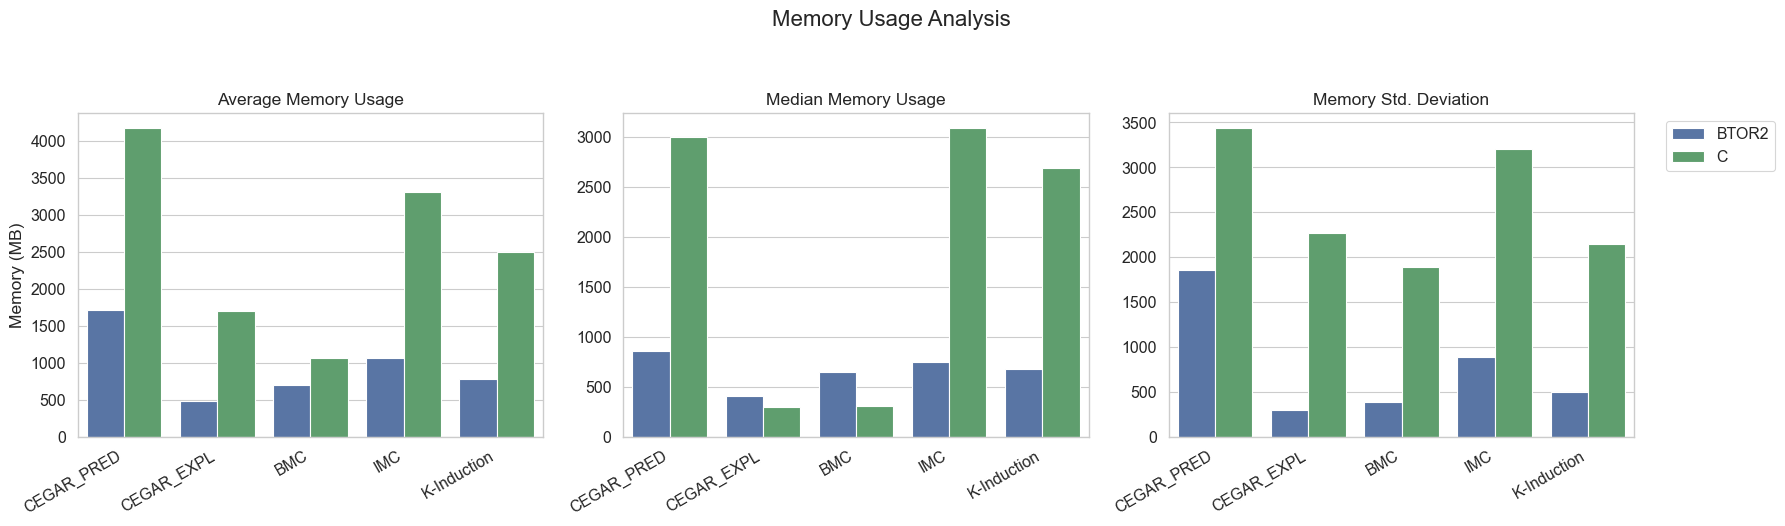

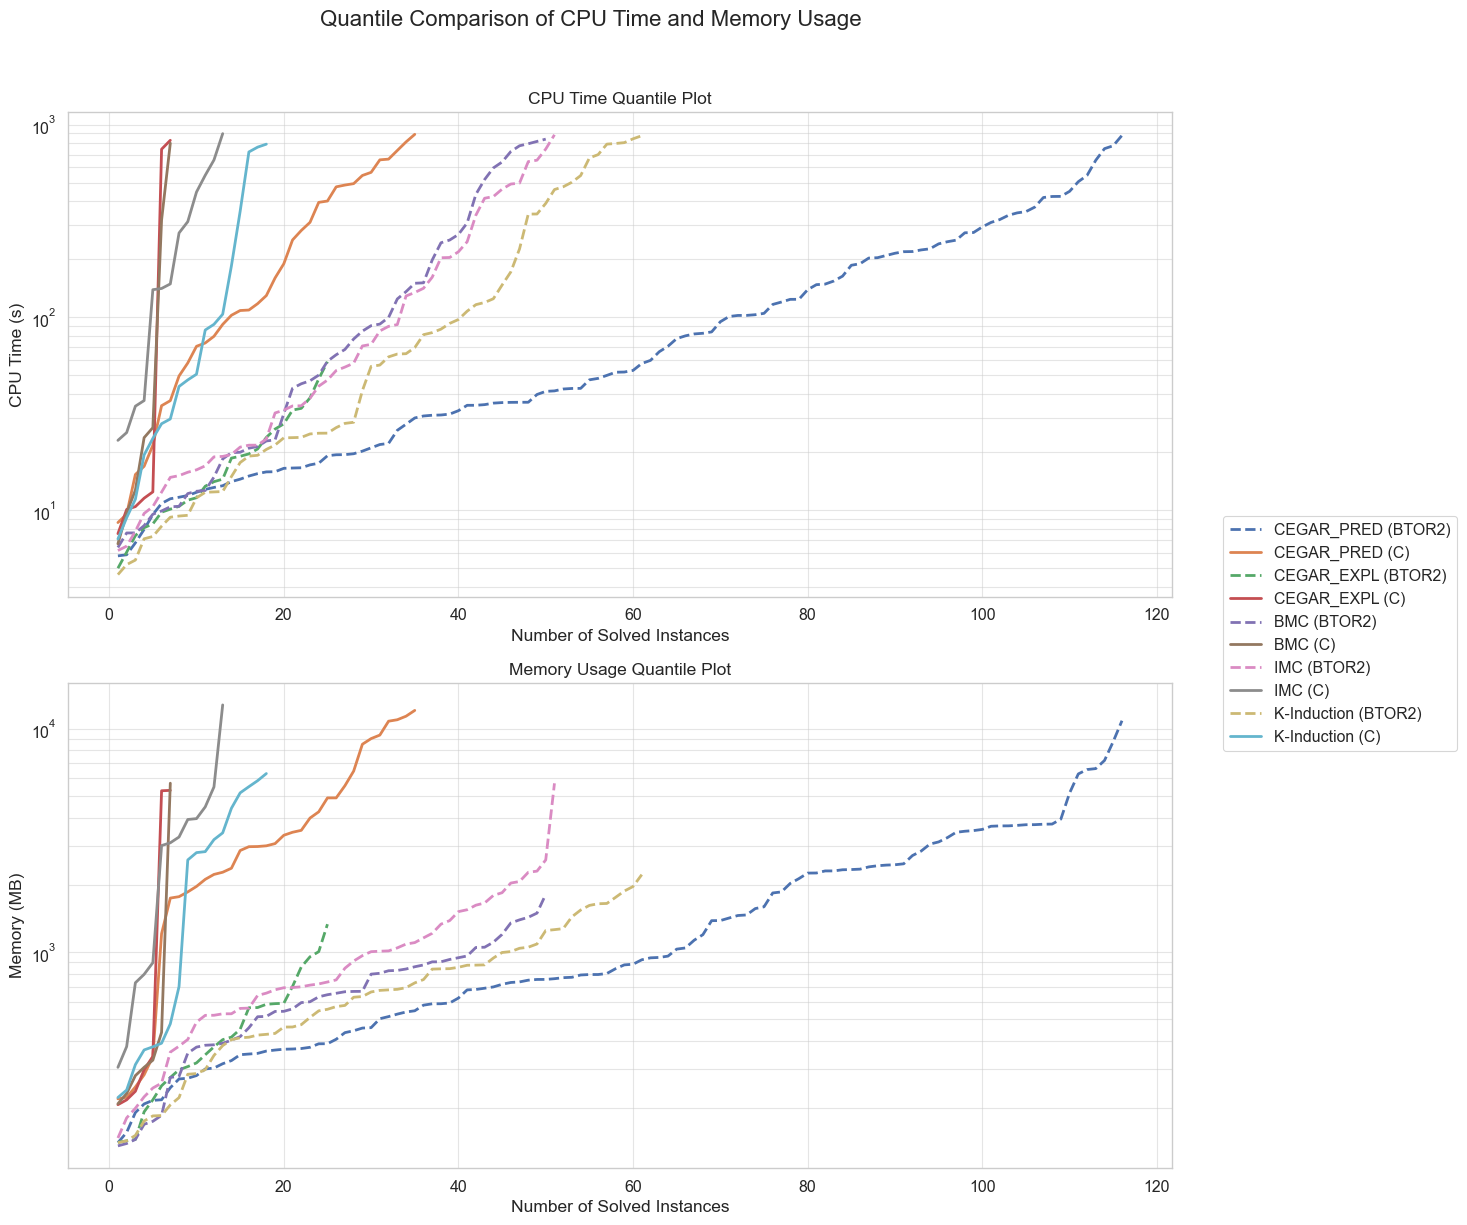

In [9]:
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

# --- Configuration ---
DATA_FOLDER = "result_xmls"

# Your specific pairs configuration
PAIRS = [
    ("CEGAR_PRED", 
     os.path.join(DATA_FOLDER, "btor2-algos-opt.2025-12-07_02-16-12.results.btor2-pred-cegar.btor2-pred.xml"), 
     os.path.join(DATA_FOLDER, "c-algos.2025-12-07_02-30-26.results.c-pred-cegar.c-pred.xml")),
    ("CEGAR_EXPL", 
     os.path.join(DATA_FOLDER, "btor2-algos-opt.2025-12-07_02-16-12.results.btor2-expl-cegar.btor2-expl.xml"), 
     os.path.join(DATA_FOLDER, "c-algos.2025-12-07_02-30-26.results.c-expl-cegar.c-expl.xml")),
    ("BMC", 
     os.path.join(DATA_FOLDER, "btor2-algos-opt.2025-12-07_02-16-12.results.btor2-bounded.btor2.xml"), 
     os.path.join(DATA_FOLDER, "c-algos.2025-12-07_02-30-26.results.c-bounded.c.xml")),
    ("IMC", 
     os.path.join(DATA_FOLDER, "btor2-algos-opt.2025-12-07_02-16-12.results.btor2-imc.btor2.xml"), 
     os.path.join(DATA_FOLDER, "c-algos.2025-12-07_02-30-26.results.c-imc.c.xml")),
    ("K-Induction", 
     os.path.join(DATA_FOLDER, "btor2-algos-opt.2025-12-07_02-16-12.results.btor2-kind.btor2.xml"), 
     os.path.join(DATA_FOLDER, "c-algos.2025-12-07_02-30-26.results.c-kind.c.xml")),
]

# --- Helper Function to Extract Stats & Raw Data ---
def get_file_data(filepath):
    """
    Parses a single XML file and returns:
    - Stats dictionary (Success rate, Mean/Median/Std for CPU & Memory)
    - Raw lists of CPU times and Memory usage (for Quantile plots)
    """
    if not os.path.exists(filepath):
        print(f"Warning: File not found: {filepath}")
        return None, None

    try:
        tree = ET.parse(filepath)
        root = tree.getroot()
        
        cputimes = []
        memories = []
        total_count = 0
        success_count = 0
        
        for run in root.findall('.//run'):
            total_count += 1
            cols = {elem.get('title'): elem.get('value') for elem in run.findall('column')}
            category = cols.get('category', run.get('category'))
            
            if category == 'correct':
                success_count += 1
                
                # Parse CPU Time
                t_str = cols.get('cputime', '0s')
                if t_str.endswith('s'):
                    cputimes.append(float(t_str.replace('s', '')))
                
                # Parse Memory
                m_str = cols.get('memory', '0B')
                if m_str.endswith('B'):
                    memories.append(float(m_str.replace('B', '')) / (1024 * 1024)) # Convert to MB

        # Calculate Statistics
        success_rate = (success_count / total_count * 100) if total_count > 0 else 0
        
        # Handle empty lists
        if cputimes:
            cpu_stats = {'avg': np.mean(cputimes), 'med': np.median(cputimes), 'std': np.std(cputimes)}
        else:
            cpu_stats = {'avg': 0, 'med': 0, 'std': 0}
            
        if memories:
            mem_stats = {'avg': np.mean(memories), 'med': np.median(memories), 'std': np.std(memories)}
        else:
            mem_stats = {'avg': 0, 'med': 0, 'std': 0}

        stats = {
            'success_rate': success_rate,
            'avg_cpu': cpu_stats['avg'], 'med_cpu': cpu_stats['med'], 'std_cpu': cpu_stats['std'],
            'avg_mem': mem_stats['avg'], 'med_mem': mem_stats['med'], 'std_mem': mem_stats['std']
        }
        
        raw_data = {
            'cputimes': sorted(cputimes), # Sorted for quantile plot
            'memories': sorted(memories)  # Sorted for quantile plot
        }
        
        return stats, raw_data

    except Exception as e:
        print(f"Error parsing {filepath}: {e}")
        return None, None

# --- Main Logic ---
summary_data = []
quantile_data = [] # To store raw data for plotting

print("Processing files...")
for algo_name, btor_file, c_file in PAIRS:
    
    # 1. Process BTOR2
    stats_btor, raw_btor = get_file_data(btor_file)
    if stats_btor:
        row = stats_btor.copy()
        row.update({'Algorithm': algo_name, 'Input Type': 'BTOR2'})
        summary_data.append(row)
        quantile_data.append({'label': f"{algo_name} (BTOR2)", 'type': 'BTOR2', 'data': raw_btor})
        
    # 2. Process C
    stats_c, raw_c = get_file_data(c_file)
    if stats_c:
        row = stats_c.copy()
        row.update({'Algorithm': algo_name, 'Input Type': 'C'})
        summary_data.append(row)
        quantile_data.append({'label': f"{algo_name} (C)", 'type': 'C', 'data': raw_c})

# Create DataFrame
df_summary = pd.DataFrame(summary_data)

# --- Summary Table ---
if not df_summary.empty:
    print("\n--- Summary Comparison Table ---")
    # ADDED: 'std_mem' to this list so it appears in the table
    cols_to_show = ['success_rate', 'avg_cpu', 'med_cpu', 'std_cpu', 'avg_mem', 'med_mem', 'std_mem']
    
    df_pivot = df_summary.pivot(index='Algorithm', columns='Input Type', values=cols_to_show)
    # Swap levels to group by Input Type or Metric (Optional: here we group by Metric)
    df_pivot = df_pivot.swaplevel(0, 1, axis=1).sort_index(axis=1)
    display(df_pivot.round(2))
    
    # --- Visualization Settings ---
    sns.set_theme(style="whitegrid", context="paper", font_scale=1.3)
    custom_palette = {"BTOR2": "#4c72b0", "C": "#55a868"} 

    # --- FIGURE 1: SUCCESS RATE ---
    plt.figure(figsize=(8, 5))
    sns.barplot(data=df_summary, x='Algorithm', y='success_rate', hue='Input Type', palette=custom_palette)
    plt.title('Success Rate Comparison')
    plt.ylabel('Success Rate (%)')
    plt.ylim(0, 105)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('comparison_fig_success.png', dpi=300)
    plt.show()

    # --- FIGURE 2: TIME ANALYSIS (Avg, Median, Std) ---
    fig2, axes2 = plt.subplots(1, 3, figsize=(18, 5))
    
    sns.barplot(data=df_summary, x='Algorithm', y='avg_cpu', hue='Input Type', ax=axes2[0], palette=custom_palette)
    axes2[0].set_title('Average CPU Time')
    axes2[0].set_ylabel('Time (s)')
    axes2[0].get_legend().remove()
    
    sns.barplot(data=df_summary, x='Algorithm', y='med_cpu', hue='Input Type', ax=axes2[1], palette=custom_palette)
    axes2[1].set_title('Median CPU Time')
    axes2[1].set_ylabel('')
    axes2[1].get_legend().remove()
    
    sns.barplot(data=df_summary, x='Algorithm', y='std_cpu', hue='Input Type', ax=axes2[2], palette=custom_palette)
    axes2[2].set_title('CPU Time Std. Deviation')
    axes2[2].set_ylabel('')
    axes2[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    for ax in axes2:
        plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
        ax.set_xlabel('')
        
    plt.suptitle("Time Complexity Analysis", y=1.05, fontsize=16)
    plt.tight_layout()
    plt.savefig('comparison_fig_time.png', dpi=300, bbox_inches='tight')
    plt.show()

    # --- FIGURE 3: MEMORY ANALYSIS (Avg, Median, Std) ---
    fig3, axes3 = plt.subplots(1, 3, figsize=(18, 5))
    
    sns.barplot(data=df_summary, x='Algorithm', y='avg_mem', hue='Input Type', ax=axes3[0], palette=custom_palette)
    axes3[0].set_title('Average Memory Usage')
    axes3[0].set_ylabel('Memory (MB)')
    axes3[0].get_legend().remove()
    
    sns.barplot(data=df_summary, x='Algorithm', y='med_mem', hue='Input Type', ax=axes3[1], palette=custom_palette)
    axes3[1].set_title('Median Memory Usage')
    axes3[1].set_ylabel('')
    axes3[1].get_legend().remove()
    
    sns.barplot(data=df_summary, x='Algorithm', y='std_mem', hue='Input Type', ax=axes3[2], palette=custom_palette)
    axes3[2].set_title('Memory Std. Deviation')
    axes3[2].set_ylabel('')
    axes3[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    for ax in axes3:
        plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
        ax.set_xlabel('')

    plt.suptitle("Memory Usage Analysis", y=1.05, fontsize=16)
    plt.tight_layout()
    plt.savefig('comparison_fig_memory.png', dpi=300, bbox_inches='tight')
    plt.show()

    # --- FIGURE 4: QUANTILE PLOTS (Cactus Plots) ---

    # 2 rows, 1 column; large clear plots
    fig4, axes4 = plt.subplots(2, 1, figsize=(12, 12))

    # Color cycle (unique color per line)
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # ---------------------------
    # 4a. CPU Time Quantile Plot
    # ---------------------------
    for i, entry in enumerate(quantile_data):
        style = '--' if entry['type'] == 'BTOR2' else '-'
        color = colors[i % len(colors)]

        y_values = entry['data']['cputimes']
        x_values = range(1, len(y_values) + 1)

        axes4[0].plot(
            x_values, y_values,
            linestyle=style,
            color=color,
            label=entry['label'],
            linewidth=2
        )

    axes4[0].set_title('CPU Time Quantile Plot')
    axes4[0].set_xlabel('Number of Solved Instances')
    axes4[0].set_ylabel('CPU Time (s)')
    axes4[0].set_yscale('log')
    axes4[0].grid(True, which="both", ls="-", alpha=0.5)

    # ------------------------------
    # 4b. Memory Usage Quantile Plot
    # ------------------------------
    for i, entry in enumerate(quantile_data):
        style = '--' if entry['type'] == 'BTOR2' else '-'
        color = colors[i % len(colors)]

        y_values = entry['data']['memories']
        x_values = range(1, len(y_values) + 1)

        axes4[1].plot(
            x_values, y_values,
            linestyle=style,
            color=color,
            label=entry['label'],
            linewidth=2
        )

    axes4[1].set_title('Memory Usage Quantile Plot')
    axes4[1].set_xlabel('Number of Solved Instances')
    axes4[1].set_ylabel('Memory (MB)')
    axes4[1].set_yscale('log')
    axes4[1].grid(True, which="both", ls="-", alpha=0.5)

    # Unified Legend
    handles, labels = axes4[0].get_legend_handles_labels()
    fig4.legend(handles, labels, loc='center left', bbox_to_anchor=(1.02, 0.5))

    plt.suptitle("Quantile Comparison of CPU Time and Memory Usage", y=1.02, fontsize=16)
    plt.tight_layout()
    plt.savefig('comparison_fig_quantile_c_btor2.png', dpi=300, bbox_inches='tight')
    plt.show()


else:
    print("No data extracted. Please check file paths.")

## timeout and out of memory rates

Processing files for failure analysis...


C:\Users\szabo\AppData\Local\Temp\ipykernel_27832\3717540181.py:107: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.barplot(data=df_fail, x='Algorithm', y='Timeout Rate (%)', hue='Input Type', ax=axes[0], palette=my_palette)
C:\Users\szabo\AppData\Local\Temp\ipykernel_27832\3717540181.py:113: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.barplot(data=df_fail, x='Algorithm', y='OOM Rate (%)', hue='Input Type', ax=axes[1], palette=my_palette)


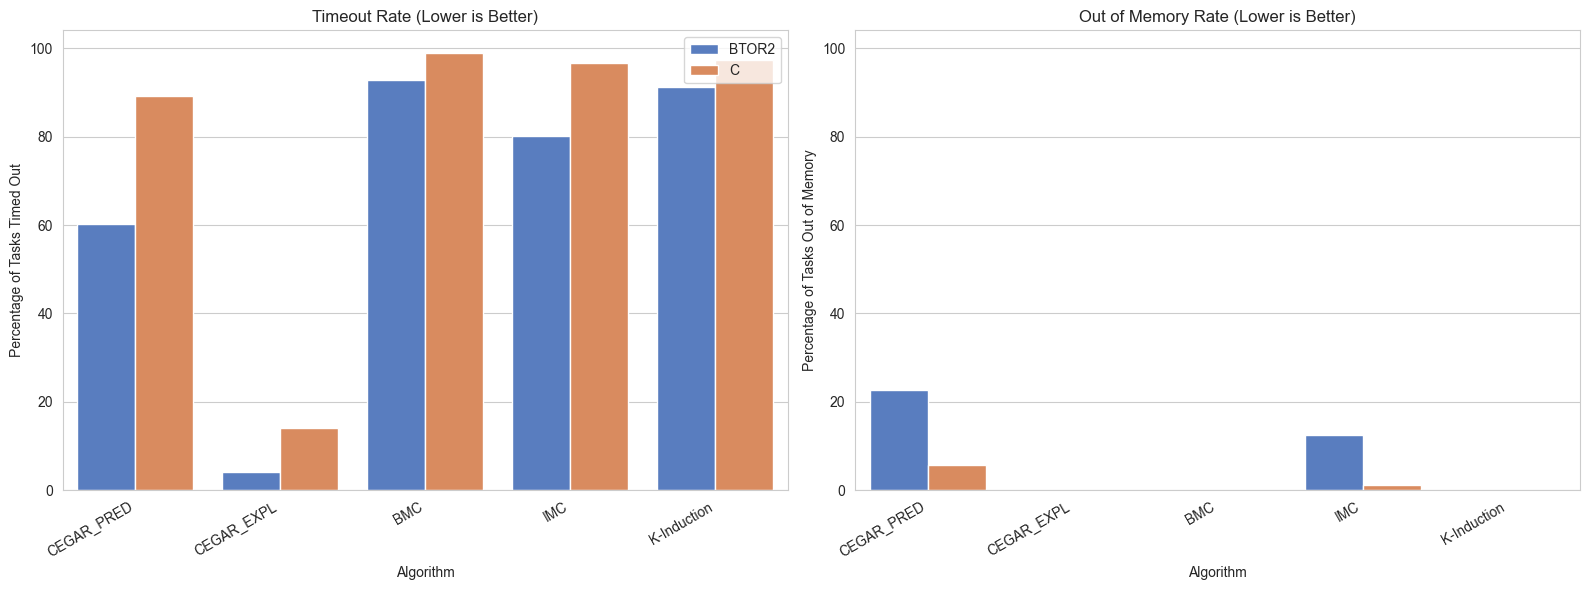


--- Failure Rates Summary ---


Input Type         BTOR2                             C                 
            OOM Rate (%) Timeout Rate (%) OOM Rate (%) Timeout Rate (%)
Algorithm                                                              
BMC                 0.00            92.84         0.00            98.99
CEGAR_EXPL          0.14             4.15         0.00            14.08
CEGAR_PRED         22.64            60.32         5.75            89.22
IMC                12.46            80.09         1.29            96.70
K-Induction         0.00            91.26         0.14            97.27

In [3]:
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Configuration ---
DATA_FOLDER = "result_xmls"

# Reusing the PAIRS list from the previous block
PAIRS = [
    ("CEGAR_PRED", 
     os.path.join(DATA_FOLDER, "btor2-algos-opt.2025-12-07_02-16-12.results.btor2-pred-cegar.btor2-pred.xml"), 
     os.path.join(DATA_FOLDER, "c-algos.2025-12-07_02-30-26.results.c-pred-cegar.c-pred.xml")),
    ("CEGAR_EXPL", 
     os.path.join(DATA_FOLDER, "btor2-algos-opt.2025-12-07_02-16-12.results.btor2-expl-cegar.btor2-expl.xml"), 
     os.path.join(DATA_FOLDER, "c-algos.2025-12-07_02-30-26.results.c-expl-cegar.c-expl.xml")),
    ("BMC", 
     os.path.join(DATA_FOLDER, "btor2-algos-opt.2025-12-07_02-16-12.results.btor2-bounded.btor2.xml"), 
     os.path.join(DATA_FOLDER, "c-algos.2025-12-07_02-30-26.results.c-bounded.c.xml")),
    ("IMC", 
     os.path.join(DATA_FOLDER, "btor2-algos-opt.2025-12-07_02-16-12.results.btor2-imc.btor2.xml"), 
     os.path.join(DATA_FOLDER, "c-algos.2025-12-07_02-30-26.results.c-imc.c.xml")),
    ("K-Induction", 
     os.path.join(DATA_FOLDER, "btor2-algos-opt.2025-12-07_02-16-12.results.btor2-kind.btor2.xml"), 
     os.path.join(DATA_FOLDER, "c-algos.2025-12-07_02-30-26.results.c-kind.c.xml")),
]

# --- Helper Function ---
def get_failure_stats(filepath):
    """
    Parses an XML file to calculate Timeout and Out of Memory (OOM) rates.
    """
    if not os.path.exists(filepath):
        return None

    try:
        tree = ET.parse(filepath)
        root = tree.getroot()
        
        total_count = 0
        timeout_count = 0
        oom_count = 0
        
        for run in root.findall('.//run'):
            total_count += 1
            
            # Get status string (e.g., "TIMEOUT (900s)", "OUT OF MEMORY")
            cols = {elem.get('title'): elem.get('value') for elem in run.findall('column')}
            status = cols.get('status', run.get('status', '')).upper()
            
            if 'TIMEOUT' in status:
                timeout_count += 1
            elif 'OUT OF MEMORY' in status:
                oom_count += 1
                
        # Calculate Rates
        timeout_rate = (timeout_count / total_count * 100) if total_count > 0 else 0
        oom_rate = (oom_count / total_count * 100) if total_count > 0 else 0
        
        return timeout_rate, oom_rate

    except Exception as e:
        print(f"Error parsing {filepath}: {e}")
        return None

# --- Main Logic ---
failure_data = []

print("Processing files for failure analysis...")
for algo_name, btor_file, c_file in PAIRS:
    
    # 1. BTOR2 Stats
    stats_btor = get_failure_stats(btor_file)
    if stats_btor:
        failure_data.append({
            'Algorithm': algo_name,
            'Input Type': 'BTOR2',
            'Timeout Rate (%)': stats_btor[0],
            'OOM Rate (%)': stats_btor[1]
        })
        
    # 2. C Stats
    stats_c = get_failure_stats(c_file)
    if stats_c:
        failure_data.append({
            'Algorithm': algo_name,
            'Input Type': 'C',
            'Timeout Rate (%)': stats_c[0],
            'OOM Rate (%)': stats_c[1]
        })

# Create DataFrame
df_fail = pd.DataFrame(failure_data)

# --- Visualization ---
if not df_fail.empty:
    sns.set_style("whitegrid")
    
    # Create 2 subplots (one for Timeout, one for OOM)
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Palette: Red for C, Blue for BTOR2 (or similar distinction)
    my_palette = sns.color_palette("muted")
    
    # 1. Timeout Rate Plot
    sns.barplot(data=df_fail, x='Algorithm', y='Timeout Rate (%)', hue='Input Type', ax=axes[0], palette=my_palette)
    axes[0].set_title('Timeout Rate (Lower is Better)')
    axes[0].set_ylabel('Percentage of Tasks Timed Out')
    axes[0].legend(loc='upper right')
    
    # 2. OOM Rate Plot
    sns.barplot(data=df_fail, x='Algorithm', y='OOM Rate (%)', hue='Input Type', ax=axes[1], palette=my_palette)
    axes[1].set_title('Out of Memory Rate (Lower is Better)')
    axes[1].set_ylabel('Percentage of Tasks Out of Memory')
    axes[1].get_legend().remove()
    
    # Formatting Labels
    for ax in axes:
        plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
        ax.set_ylim(0, max(df_fail['Timeout Rate (%)'].max(), df_fail['OOM Rate (%)'].max()) + 5)

    plt.tight_layout()
    plt.show()
    
    # --- Summary Table ---
    print("\n--- Failure Rates Summary ---")
    df_pivot = df_fail.pivot(index='Algorithm', columns='Input Type')
    df_pivot = df_pivot.swaplevel(0, 1, axis=1).sort_index(axis=1)
    display(df_pivot.round(2))
else:
    print("No data processed.")

In [ ]:
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Configuration ---
DATA_FOLDER = "result_xmls"

# Reusing the PAIRS list from the previous block
PAIRS = [
    ("CEGAR_PRED", 
     os.path.join(DATA_FOLDER, "btor2-algos-opt.2025-12-07_02-16-12.results.btor2-pred-cegar.btor2-pred.xml"), 
     os.path.join(DATA_FOLDER, "c-algos.2025-12-07_02-30-26.results.c-pred-cegar.c-pred.xml")),
    ("CEGAR_EXPL", 
     os.path.join(DATA_FOLDER, "btor2-algos-opt.2025-12-07_02-16-12.results.btor2-expl-cegar.btor2-expl.xml"), 
     os.path.join(DATA_FOLDER, "c-algos.2025-12-07_02-30-26.results.c-expl-cegar.c-expl.xml")),
    ("BMC", 
     os.path.join(DATA_FOLDER, "btor2-algos-opt.2025-12-07_02-16-12.results.btor2-bounded.btor2.xml"), 
     os.path.join(DATA_FOLDER, "c-algos.2025-12-07_02-30-26.results.c-bounded.c.xml")),
    ("IMC", 
     os.path.join(DATA_FOLDER, "btor2-algos-opt.2025-12-07_02-16-12.results.btor2-imc.btor2.xml"), 
     os.path.join(DATA_FOLDER, "c-algos.2025-12-07_02-30-26.results.c-imc.c.xml")),
    ("K-Induction", 
     os.path.join(DATA_FOLDER, "btor2-algos-opt.2025-12-07_02-16-12.results.btor2-kind.btor2.xml"), 
     os.path.join(DATA_FOLDER, "c-algos.2025-12-07_02-30-26.results.c-kind.c.xml")),
]
